# Data-Driven Discovery of a Discrete-Time Recurrence

$\hat{x}_k = g_\phi(x_{k-1}, x_{k-2}, \ldots, x_{k-p})$

$\sum_{k=0}^{x_k} T$

$\hat{x}_k = F_\phi(x_{k-1}, x_{k-2}, \ldots, x_{k-p^{\hat{}}})$

$\{x_k\}_{k=0}^T$

$(\mathbf{h}_k \mapsto x_k)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
import math
import random

device = torch.device("cpu")
print("Using device:", device)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

ROOT = Path.cwd().parent
DATA_Q2 = ROOT / "Data" / "Q2" / "recurrence_timeseries.csv"
print("Data path:", DATA_Q2)

USERNAME = "atharv.bhatt"

def add_username(fig):
    fig.text(0.99, 0.01, USERNAME, ha="right", va="bottom", fontsize=8)

def mse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

Using device: cpu
Data path: c:\Users\athar\Documents\VS_Code\SEM_5\SMAI\assignment-5-atharvv04\Data\Q2\recurrence_timeseries.csv


Total length: 54000
First 10 values: [ 0.364704 -0.892358 -0.55928  -0.631256 -0.648188  0.624189  0.84669
 -0.446851 -0.298837 -0.112003]
Min / Max: -0.999627 0.999707


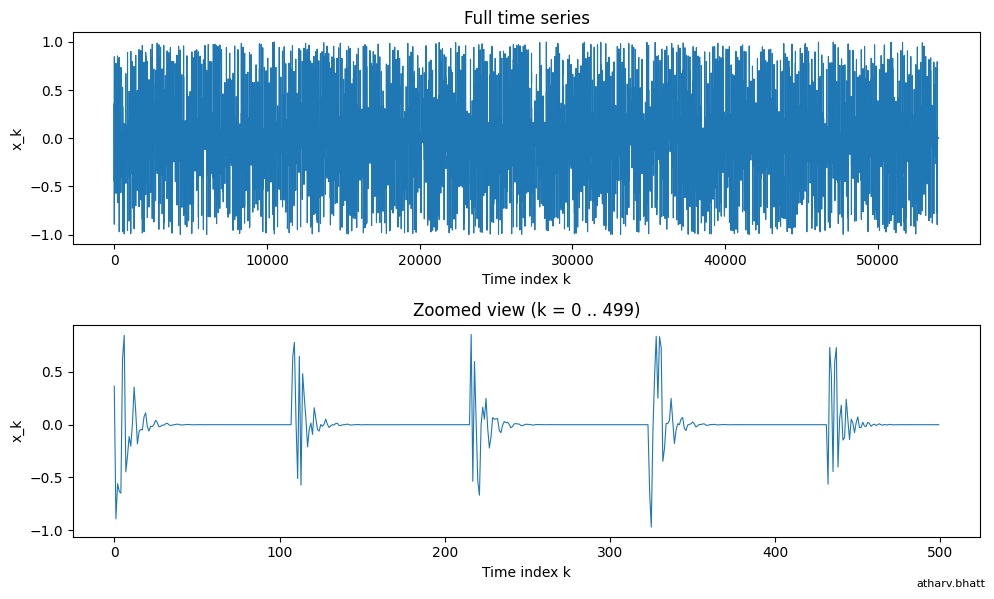

In [2]:
# Load the single long univariate sequence
df = pd.read_csv(DATA_Q2)
assert "x_value" in df.columns, df.columns

series = df["x_value"].values.astype(np.float32)
N = len(series)
print("Total length:", N)
print("First 10 values:", series[:10])
print("Min / Max:", series.min(), series.max())

# Quick visualization of the entire sequence and a zoomed-in window
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

axes[0].plot(series, linewidth=0.8)
axes[0].set_title("Full time series")
axes[0].set_xlabel("Time index k")
axes[0].set_ylabel("x_k")

zoom_start = 0
zoom_end = min(500, N)
axes[1].plot(np.arange(zoom_start, zoom_end), series[zoom_start:zoom_end], linewidth=0.8)
axes[1].set_title(f"Zoomed view (k = {zoom_start} .. {zoom_end-1})")
axes[1].set_xlabel("Time index k")
axes[1].set_ylabel("x_k")

plt.tight_layout()
add_username(fig)
plt.show()

In [3]:
# Chronological split: 60% train, 20% val, 20% test
n_train = int(0.6 * N)
n_val   = int(0.8 * N)

train_seq = series[:n_train]
val_seq   = series[n_train:n_val]
test_seq  = series[n_val:]

print(f"Train length: {len(train_seq)}")
print(f"Val length  : {len(val_seq)}")
print(f"Test length : {len(test_seq)}")

# Normalization from training set only
train_mean = train_seq.mean()
train_std  = train_seq.std()
print("Train mean/std:", train_mean, train_std)

def normalize(x):
    return (x - train_mean) / train_std

def denormalize(x_norm):
    return x_norm * train_std + train_mean

train_seq_norm = normalize(train_seq)
val_seq_norm   = normalize(val_seq)
test_seq_norm  = normalize(test_seq)

print("Normalized train stats (mean ~0, std~1):", train_seq_norm.mean(), train_seq_norm.std())
print("Normalized val stats   (mean ~0, std~1):", val_seq_norm.mean(), val_seq_norm.std())
print("Normalized test stats  (mean ~0, std~1):", test_seq_norm.mean(), test_seq_norm.std())

Train length: 32400
Val length  : 10800
Test length : 10800
Train mean/std: -0.00089038577 0.16075173
Normalized train stats (mean ~0, std~1): -5.8868785e-11 1.0
Normalized val stats   (mean ~0, std~1): 0.006080756 1.0237205
Normalized test stats  (mean ~0, std~1): 0.0004587117 0.9925078


Example X[0] (p=3): [-3.473615  -5.5456176  2.2742796]
Example y[0]: -3.9213612
Shapes: (32397, 3) (32397,)


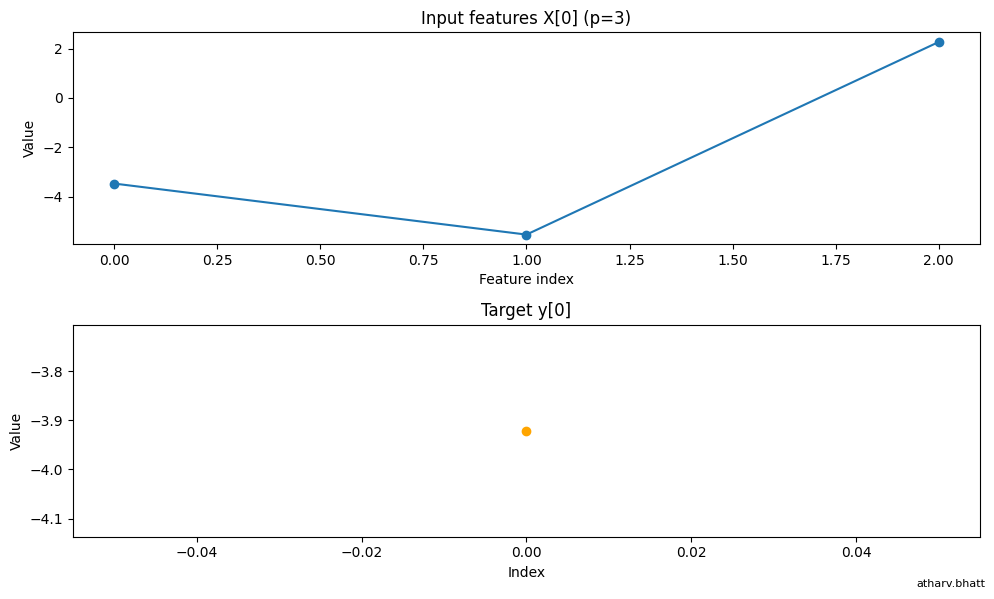

In [4]:
def make_supervised_pairs(sequence, p):
    """
    sequence : 1D numpy array (normalized)
    p        : history length

    Returns
    -------
    X : (num_pairs, p)
        Each row [x_{k-1}, x_{k-2}, ..., x_{k-p}]
    y : (num_pairs,)
        Each element x_k
    """
    seq = np.asarray(sequence, dtype=np.float32)
    if len(seq) <= p:
        raise ValueError("Sequence too short for history length p.")

    X = []
    y = []
    for k in range(p, len(seq)):
        hist = seq[k-p:k][::-1]   # reverse so [x_{k-1}, x_{k-2}, ..., x_{k-p}]
        X.append(hist)
        y.append(seq[k])
    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.float32)
    return X, y

# Quick sanity check for p=3
X_train_3, y_train_3 = make_supervised_pairs(train_seq_norm, p=3)
print("Example X[0] (p=3):", X_train_3[0])
print("Example y[0]:", y_train_3[0])
print("Shapes:", X_train_3.shape, y_train_3.shape)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)
axes[0].plot(X_train_3[0], marker='o')
axes[0].set_title("Input features X[0] (p=3)")
axes[0].set_xlabel("Feature index")
axes[0].set_ylabel("Value")
axes[1].plot(y_train_3[0], marker='o', color='orange')
axes[1].set_title("Target y[0]")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")
plt.tight_layout()
add_username(fig)
plt.show()

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_dataloaders(p, batch_size=64, shuffle_train=True):
    """
    Build dataloaders for a given history length p.
    Uses normalized sequences and concatenates across the single long series.
    """
    X_train, y_train = make_supervised_pairs(train_seq_norm, p)
    X_val,   y_val   = make_supervised_pairs(val_seq_norm, p)
    X_test,  y_test  = make_supervised_pairs(test_seq_norm, p)

    train_ds = TimeSeriesDataset(X_train, y_train)
    val_ds   = TimeSeriesDataset(X_val,   y_val)
    test_ds  = TimeSeriesDataset(X_test,  y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [6]:
class LinearAR(nn.Module):
    """
    Linear AR(p) model:
    x_hat_k = b + sum_{i=1}^p w_i * x_{k-i}
    """
    def __init__(self, p):
        super().__init__()
        self.linear = nn.Linear(p, 1)

    def forward(self, x):
        # x: (batch, p)
        return self.linear(x).squeeze(-1)


class RNNPredictor(nn.Module):
    """
    Small GRU-based predictor.
    Input: history of length p as a sequence (p, 1)
    Output: scalar prediction x_hat_k
    """
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, p) --> reshape to (batch, p, 1)
        x_seq = x.unsqueeze(-1)
        out, h = self.rnn(x_seq)
        last_h = out[:, -1, :]  # (batch, hidden_size)
        return self.fc(last_h).squeeze(-1)


class MLPPredictor(nn.Module):
    """
    Simple MLP baseline mapping history vector -> x_hat_k.
    """
    def __init__(self, p, hidden_size=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # x: (batch, p)
        return self.net(x).squeeze(-1)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
def train_model(model, train_loader, val_loader,
                num_epochs=50, lr=1e-3, verbose=True):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        train_loss_sum = 0.0
        n_train = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * len(y_batch)
            n_train += len(y_batch)

        epoch_train_loss = train_loss_sum / n_train
        train_losses.append(epoch_train_loss)

        # ---- Validation ----
        model.eval()
        val_loss_sum = 0.0
        n_val = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                preds = model(X_batch)
                loss = criterion(preds, y_batch)

                val_loss_sum += loss.item() * len(y_batch)
                n_val += len(y_batch)

        epoch_val_loss = val_loss_sum / n_val
        val_losses.append(epoch_val_loss)

        if verbose and (epoch % 10 == 0 or epoch == num_epochs-1):
            print(f"Epoch {epoch+1:03d}/{num_epochs} "
                  f"Train MSE={epoch_train_loss:.4f} Val MSE={epoch_val_loss:.4f}")

    return train_losses, val_losses


def evaluate_single_step(model, data_loader):
    """
    Evaluate MSE, MAE on a dataloader (single-step prediction).
    Returns metrics and the concatenated predictions & targets.
    """
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)

            all_true.append(y_batch.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    return mse(y_true, y_pred), mae(y_true, y_pred), y_true, y_pred

#### Hyperparameter sweep over p and models (2.2 & 2.5)

In [ ]:
p_values = [1, 2, 3, 4, 5, 6, 8]
hidden_sizes_rnn = [8, 16]
hidden_sizes_mlp = [16, 32]

results = []

for p in p_values:
    print(f"\n=== History length p = {p} ===")
    train_loader, val_loader, test_loader = make_dataloaders(p, batch_size=128)

    # ----- Linear AR(p) -----
    ar_model = LinearAR(p)
    print(f"Training LinearAR(p={p}), params={count_parameters(ar_model)}")
    train_losses_ar, val_losses_ar = train_model(
        ar_model, train_loader, val_loader,
        num_epochs=60, lr=1e-3, verbose=False
    )
    val_mse_ar, val_mae_ar, _, _ = evaluate_single_step(ar_model, val_loader)
    results.append({
        "model": "AR",
        "p": p,
        "hidden_size": None,
        "num_layers": None,
        "num_params": count_parameters(ar_model),
        "val_mse": val_mse_ar,
        "val_mae": val_mae_ar
    })
    print(f"  AR: Val MSE={val_mse_ar:.4f}, Val MAE={val_mae_ar:.4f}")

    # ----- RNNs -----
    for hs in hidden_sizes_rnn:
        rnn_model = RNNPredictor(input_size=1, hidden_size=hs, num_layers=1)
        print(f"Training RNN(p={p}, hidden={hs}), params={count_parameters(rnn_model)}")
        train_losses_rnn, val_losses_rnn = train_model(
            rnn_model, train_loader, val_loader,
            num_epochs=60, lr=1e-3, verbose=False
        )
        val_mse_rnn, val_mae_rnn, _, _ = evaluate_single_step(rnn_model, val_loader)
        results.append({
            "model": "RNN",
            "p": p,
            "hidden_size": hs,
            "num_layers": 1,
            "num_params": count_parameters(rnn_model),
            "val_mse": val_mse_rnn,
            "val_mae": val_mae_rnn
        })
        print(f"  RNN(h={hs}): Val MSE={val_mse_rnn:.4f}, Val MAE={val_mae_rnn:.4f}")

    # ----- Optional MLPs -----
    for hs in hidden_sizes_mlp:
        mlp_model = MLPPredictor(p, hidden_size=hs)
        print(f"Training MLP(p={p}, hidden={hs}), params={count_parameters(mlp_model)}")
        train_losses_mlp, val_losses_mlp = train_model(
            mlp_model, train_loader, val_loader,
            num_epochs=60, lr=1e-3, verbose=False
        )
        val_mse_mlp, val_mae_mlp, _, _ = evaluate_single_step(mlp_model, val_loader)
        results.append({
            "model": "MLP",
            "p": p,
            "hidden_size": hs,
            "num_layers": None,
            "num_params": count_parameters(mlp_model),
            "val_mse": val_mse_mlp,
            "val_mae": val_mae_mlp
        })
        print(f"  MLP(h={hs}): Val MSE={val_mse_mlp:.4f}, Val MAE={val_mae_mlp:.4f}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df
results_df.sort_values(by="val_mse")


=== History length p = 1 ===
Training LinearAR(p=1), params=2
  AR: Val MSE=1.0413, Val MAE=0.3195
Training RNN(p=1, hidden=8), params=273
  RNN(h=8): Val MSE=1.0372, Val MAE=0.3139
Training RNN(p=1, hidden=16), params=929
  RNN(h=16): Val MSE=1.0380, Val MAE=0.3164
Training MLP(p=1, hidden=16), params=49
  MLP(h=16): Val MSE=1.0371, Val MAE=0.3143
Training MLP(p=1, hidden=32), params=97
  MLP(h=32): Val MSE=1.0413, Val MAE=0.3246

=== History length p = 2 ===
Training LinearAR(p=2), params=3
  AR: Val MSE=1.0390, Val MAE=0.3154
Training RNN(p=2, hidden=8), params=273
  RNN(h=8): Val MSE=1.0250, Val MAE=0.3036
Training RNN(p=2, hidden=16), params=929
  RNN(h=16): Val MSE=1.0259, Val MAE=0.3107
Training MLP(p=2, hidden=16), params=65


#### Pick best models and inspect the AR recurrence (2.3, 2.5)

In [ ]:
# Find best AR (lowest val_mse)
best_ar_row = results_df[results_df["model"] == "AR"].sort_values("val_mse").iloc[0]
p_hat = int(best_ar_row["p"])
print("Best AR order p_hat:", p_hat)
best_ar_row

# Re-train best AR model on train+val for final coefficients
# (optional but nicer; or just reuse previous trained model)
full_train_seq_norm = np.concatenate([train_seq_norm, val_seq_norm])
X_full, y_full = make_supervised_pairs(full_train_seq_norm, p_hat)
full_train_ds = TimeSeriesDataset(X_full, y_full)
full_train_loader = DataLoader(full_train_ds, batch_size=128, shuffle=True)

best_ar_model = LinearAR(p_hat)
print("Training best AR model on train+val...")
_ = train_model(best_ar_model, full_train_loader, full_train_loader,
                num_epochs=80, lr=1e-3, verbose=False)

# Extract coefficients
with torch.no_grad():
    W = best_ar_model.linear.weight.cpu().numpy().flatten()
    b = float(best_ar_model.linear.bias.cpu().item())

print("AR coefficients (w_1,...,w_p):", W)
print("AR bias b:", b)
print("Number of params:", count_parameters(best_ar_model))

#### Evaluate single-step on test for AR & best RNN (2.4)

In [ ]:
# Identify best RNN configuration
best_rnn_row = results_df[results_df["model"] == "RNN"].sort_values("val_mse").iloc[0]
p_rnn = int(best_rnn_row["p"])
hidden_rnn = int(best_rnn_row["hidden_size"])
print("Best RNN config:", best_rnn_row)

# Build loaders for the chosen p values
train_loader_ar, val_loader_ar, test_loader_ar = make_dataloaders(p_hat, batch_size=128)
train_loader_rnn, val_loader_rnn, test_loader_rnn = make_dataloaders(p_rnn, batch_size=128)

# Re-train best RNN on train+val
print("Training best RNN on train+val...")
full_train_seq_norm_rnn = np.concatenate([train_seq_norm, val_seq_norm])
X_full_rnn, y_full_rnn = make_supervised_pairs(full_train_seq_norm_rnn, p_rnn)
full_train_ds_rnn = TimeSeriesDataset(X_full_rnn, y_full_rnn)
full_train_loader_rnn = DataLoader(full_train_ds_rnn, batch_size=128, shuffle=True)

best_rnn_model = RNNPredictor(input_size=1, hidden_size=hidden_rnn, num_layers=1)
_ = train_model(best_rnn_model, full_train_loader_rnn, full_train_loader_rnn,
                num_epochs=80, lr=1e-3, verbose=False)

# Single-step test evaluation
test_mse_ar, test_mae_ar, y_true_ar, y_pred_ar = evaluate_single_step(best_ar_model, test_loader_ar)
test_mse_rnn, test_mae_rnn, y_true_rnn, y_pred_rnn = evaluate_single_step(best_rnn_model, test_loader_rnn)

print(f"Test AR(p={p_hat})  : MSE={test_mse_ar:.4f}, MAE={test_mae_ar:.4f}")
print(f"Test RNN(p={p_rnn}) : MSE={test_mse_rnn:.4f}, MAE={test_mae_rnn:.4f}")

# Optional: plot a small segment of predictions vs ground truth (denormalized)
segment_len = 200
y_true_den = denormalize(y_true_ar[:segment_len])
y_pred_ar_den = denormalize(y_pred_ar[:segment_len])

plt.figure(figsize=(10,4))
plt.plot(y_true_den, label="True", linewidth=1)
plt.plot(y_pred_ar_den, label="AR prediction", linewidth=1)
plt.title("Single-step predictions on test (first 200 points)")
plt.xlabel("Index")
plt.ylabel("x_k")
plt.legend()
plt.tight_layout()
add_username(plt.gcf())
plt.show()

y_pred_rnn_den = denormalize(y_pred_rnn[:segment_len])

plt.figure(figsize=(10,4))
plt.plot(y_true_den, label="True", linewidth=1)
plt.plot(y_pred_rnn_den, label="RNN prediction", linewidth=1)
plt.title("Single-step predictions on test (first 200 points)")
plt.xlabel("Index")
plt.ylabel("x_k")
plt.legend()
plt.tight_layout()
add_username(plt.gcf())
plt.show()

#### Multi-step autoregressive forecasting & error vs horizon (2.4)

In [ ]:
def multi_step_forecast(model, seq_norm, p, horizon):
    """
    Given a normalized sequence seq_norm, use last p values as initial history
    and generate 'horizon' future steps autoregressively.
    Returns arrays (y_true, y_pred) in original (denormalized) scale.
    """
    seq_norm = np.asarray(seq_norm, dtype=np.float32)
    assert len(seq_norm) > p + horizon

    # Use last (p + horizon) portion of the test sequence
    start = len(seq_norm) - (p + horizon)
    segment = seq_norm[start:]
    history = segment[:p].copy()  # initial history
    true_future = segment[p:p+horizon]

    model.eval()
    preds = []

    with torch.no_grad():
        hist = history.copy()
        for h in range(horizon):
            X = torch.from_numpy(hist[::-1].copy()[None, :]).float().to(device)  # shape (1, p)
            y_hat = model(X).cpu().numpy().flatten()[0]
            preds.append(y_hat)

            # update history
            hist = np.concatenate([hist[1:], np.array([y_hat], dtype=np.float32)])

    true_den = denormalize(true_future)
    pred_den = denormalize(np.array(preds, dtype=np.float32))
    return true_den, pred_den


H_max = 50
horizons = np.arange(1, H_max+1)
errors_ar = []
errors_rnn = []

test_seq_combined_norm = test_seq_norm  # using full test sequence

for H in horizons:
    y_true_ar_h, y_pred_ar_h = multi_step_forecast(best_ar_model, test_seq_combined_norm, p_hat, H)
    y_true_rnn_h, y_pred_rnn_h = multi_step_forecast(best_rnn_model, test_seq_combined_norm, p_rnn, H)

    errors_ar.append(mse(y_true_ar_h, y_pred_ar_h))
    errors_rnn.append(mse(y_true_rnn_h, y_pred_rnn_h))

plt.figure(figsize=(8,4))
plt.plot(horizons, errors_ar, label=f"AR(p={p_hat})")
plt.plot(horizons, errors_rnn, label=f"RNN(p={p_rnn}, h={hidden_rnn})")
plt.xlabel("Forecast horizon (steps ahead)")
plt.ylabel("MSE")
plt.title("Multi-step forecast error vs horizon")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
add_username(plt.gcf())
plt.show()


H_show = 100
y_true_long, y_pred_ar_long = multi_step_forecast(best_ar_model, test_seq_combined_norm, p_hat, H_show)
_,            y_pred_rnn_long = multi_step_forecast(best_rnn_model, test_seq_combined_norm, p_rnn, H_show)

plt.figure(figsize=(10,4))
plt.plot(y_true_long, label="True future", linewidth=1)
plt.plot(y_pred_ar_long, label="AR forecast", linewidth=1)
plt.plot(y_pred_rnn_long, label="RNN forecast", linewidth=1)
plt.xlabel("Step ahead")
plt.ylabel("x_k")
plt.title("Example multi-step forecasts (H=100)")
plt.legend()
plt.tight_layout()
add_username(plt.gcf())
plt.show()

In [ ]:
# Plot val MSE vs parameter count for all models
plt.figure(figsize=(7,5))

for model_name, marker in [("AR", "o"), ("RNN", "s"), ("MLP", "^")]:
    subset = results_df[results_df["model"] == model_name]
    if len(subset) == 0:
        continue
    plt.scatter(subset["num_params"], subset["val_mse"],
                label=model_name, marker=marker)

plt.xscale("log")
plt.xlabel("Number of trainable parameters (log scale)")
plt.ylabel("Validation MSE")
plt.title("Complexity–accuracy trade-off")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
add_username(plt.gcf())
plt.show()

results_df.sort_values("val_mse").head(10)